# Humor detection (binary classification) на английском языке, используя BERT

Задача распознавания юмора довольно сложная задача для ЛЛМ-ок, в данной работе предпринята попытка улучшения качества распознавания юмора при zero- и few-shot с улучшением RAG подходом.

Ссылка на корпус: https://huggingface.co/datasets/CreativeLang/ColBERT_Humor_Detection

## Zero-shot

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelWithLMHead

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("CreativeLang/ColBERT_Humor_Detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

dataset.csv:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(data=[ds['train']['text'], ds['train']['humor']], index=['Text', 'Binary']).T

In [ ]:
df

,Text,Binary
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


In [ ]:
MODEL_NAME = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelWithLMHead.from_pretrained(MODEL_NAME).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1833: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
pattern_1 = "Analyze the given text and determine whether it is 'Humorous' or 'Not.' {0}'. Is it humorous? Your response: <mask>."
pattern_2 = "Here is a joke: {0}. Is it funny? Your response: <mask>."
pattern_3 = 'Here is a text: {0}. Say: is it good or bad? Your opinion: <mask>.'

pattern_4 = "I heard a joke: {0}. What's you opinion? Your response: it's <mask> funny."

pattern_5 = "I'm writing a comedy show. The joke: {0}. Do you find this joke funny? My friend says it's <mask>."
pattern_6 = '- Adam, here is a joke: {0}. Is it funny? - Bill, it is <mask>.'
pattern_7 = "- Adam, here is a joke: {0}. Is it funny? - It's really <mask>."

In [ ]:
def format_with_pattern(tokenizer, pattern, text):
    augmented_text = pattern.format(text).replace("<mask>", tokenizer.mask_token)
    tokenization = tokenizer(augmented_text)["input_ids"]
    mask_index = tokenization.index(tokenizer.mask_token_id)
    return tokenization, mask_index

In [ ]:
def score_with_model(tokenization, index, device="cuda"):
    tensor = torch.LongTensor([tokenization]).to(device)
    with torch.no_grad():
        model_output = model(tensor)
    logits = model_output.logits[0]
    log_probs = torch.log_softmax(logits[index], dim=-1)
    return log_probs

In [ ]:
!pip install spacy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Сравнение косинусной близостм выдаваемых результатов со "стандартом" для решения, классифицирует ли модель подаваемые результаты как положительные или нет.

In [ ]:
def cosine_similarity(input_phrase, add_info=None):
    input = nlp(input_phrase)
    vector = input.vector
    if add_info is None:
        standard = ['funny', 'good', 'hilarious', 'amusing', 'beautiful', 'amazing']
        not_standard = ['stupid', 'sad', 'bad', 'awful', 'dreary', 'depressing', 'tragic', 'sad', 'disturbing', 'frustrating']
    else:
        standard = add_info[0]
        not_standard = add_info[1]
    # standard = ['positive', 'good']
    # not_standard = ['negative', 'bad']
    standard_vectors = [nlp(phrase).vector for phrase in standard]
    not_standard_vectors = [nlp(phrase).vector for phrase in not_standard]
    cos_sim_scores = [np.dot(vector, sv) / (np.linalg.norm(vector) * np.linalg.norm(sv)) for sv in standard_vectors]
    cos_not_sim_scores = [np.dot(vector, sv) / (np.linalg.norm(vector) * np.linalg.norm(sv)) for sv in not_standard_vectors]
    return 1 if np.mean(cos_sim_scores) > np.mean(cos_not_sim_scores) else 0

Протестируем способность модели на первых 200 примерах.

Для начала пройдемся по базовым промптам:



```
pattern_1 = "Analyze the given text and determine whether it is 'Humorous' or 'Not.' {0}'. Is it humorous? Your response: <mask>."
pattern_2 = "Here is a joke: {0}. Is it funny? Your response: <mask>."
pattern_3 = 'Here is a text: {0}. Say: is it good or bad? Your opinion: <mask>.'
```



In [ ]:
corpus, labels = list(df['Text'][:200]), [int(x) for x in df['Binary'][:200]]

def basic_prompt_prediction(pattern, corpus, add_info=None):
    preds = []
    for text, label in zip(corpus, labels):
        tokenization, mask_index = format_with_pattern(tokenizer, pattern, text)
        log_probs = score_with_model(tokenization, mask_index)
        top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
        pos_prob, neg_prob = 0, 0
        for log_prob, index in zip(top_probs, top_indexes):
            probability = np.exp(log_prob.item())
            input = tokenizer.decode([index]).replace(' ', '')
            if input.lower() in ['no', 'not', 'bad']:
                neg_prob += probability
            elif input.lower() in ['yes', 'yeah', 'good']:
                pos_prob += probability
            else:
                if cosine_similarity(input.replace(" ", ""), add_info):
                    pos_prob += probability
                else:
                    neg_prob += probability
        preds.append(int(pos_prob > neg_prob))
    return preds

In [ ]:
preds_1 = basic_prompt_prediction(pattern_1, corpus)

In [ ]:
preds_2 = basic_prompt_prediction(pattern_2, corpus)

In [ ]:
preds_3 = basic_prompt_prediction(pattern_3, corpus)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['False', 'True']
print(classification_report(labels, preds_1, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.53      1.00      0.69       105
        True       0.00      0.00      0.00        95

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200



In [ ]:
print(classification_report(labels, preds_2, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.45      0.23      0.30       105
        True       0.45      0.69      0.55        95

    accuracy                           0.45       200
   macro avg       0.45      0.46      0.42       200
weighted avg       0.45      0.45      0.42       200



In [ ]:
print(classification_report(labels, preds_3, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       1.00      0.10      0.17       105
        True       0.50      1.00      0.67        95

    accuracy                           0.53       200
   macro avg       0.75      0.55      0.42       200
weighted avg       0.76      0.53      0.41       200



Как я и предполагала, модель не умеет воспринимать нормально юмор. Она либо все считает несмешным (как в первом пропмте), либо просто некачественно работает.

Есть идея попробовать, во-первых, маскировать слово перед funny: она там предскажет либо *not*, либо усиляющий какой-нибудь типа *really*



```
pattern_4 = "I heard a joke: {0}. What's you opinion? Your response: it's <mask> funny."
```



In [ ]:
corpus, labels = list(df['Text'][:200]), [int(x) for x in df['Binary'][0:200]]
preds_4 = basic_prompt_prediction(pattern_4, corpus, add_info=[['really', 'rather', 'still', 'even'], ['not', 'no']])

In [ ]:
print(classification_report(labels, preds_4, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.45      0.55      0.50       105
        True       0.34      0.25      0.29        95

    accuracy                           0.41       200
   macro avg       0.39      0.40      0.39       200
weighted avg       0.40      0.41      0.40       200



Еще одна идея заключается в более "живых" промптах. То есть использовать креативную сторону модели, как бы давая ей диалог, где нужно угадать маскированное слово.

```
pattern_5 = "I'm writing a comedy show. The joke: {0}. Do you find this joke funny? My friend says it's <mask>."
pattern_6 = '- Adam, here is a joke: {0}. Is it funny? - Bill, it is <mask>.'
pattern_7 = "- Adam, here is a joke: {0}. Is it funny? - It's really <mask>."
```



In [ ]:
corpus, labels = list(df['Text'][:200]), [int(x) for x in df['Binary'][:200]]

def advanced_prompt_prediction(pattern, corpus, add_info=None):
    preds = []
    for text, label in zip(corpus, labels):
        tokenization, mask_index = format_with_pattern(tokenizer, pattern, text)
        log_probs = score_with_model(tokenization, mask_index)
        top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
        pos_prob, neg_prob = 0, 0
        for log_prob, index in zip(top_probs, top_indexes):
            probability = np.exp(log_prob.item())
            input = tokenizer.decode([index]).replace(' ', '')
            if cosine_similarity(input.replace(" ", ""), add_info):
                pos_prob += probability
            else:
                neg_prob += probability
        preds.append(int(pos_prob > neg_prob))
    return preds

In [ ]:
preds_5 = advanced_prompt_prediction(pattern_5, corpus)

In [ ]:
print(classification_report(labels, preds_5, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       105
        True       0.47      1.00      0.64        95

    accuracy                           0.47       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.47      0.31       200



In [ ]:
preds_6 = advanced_prompt_prediction(pattern_6, corpus)

In [ ]:
print(classification_report(labels, preds_6, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       105
        True       0.47      1.00      0.64        95

    accuracy                           0.47       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.47      0.31       200



In [ ]:
preds_7 = advanced_prompt_prediction(pattern_6, corpus)

In [ ]:
print(classification_report(labels, preds_7, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       105
        True       0.47      1.00      0.64        95

    accuracy                           0.47       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.47      0.31       200



Качество очень случайное, в зависимости от промта у модели bias то в сторону отсутствия юмора, то нет. Но здесь стоит еще проверить более эвристическим методом, возможно, проблема с векторами spacy – зачастую странно высчитывается косинусная близость. Попробуем смотреть по самому вероятному слову, так как промпты подразумевают грамматичность как *not*, так и синонимов *funny*.



In [ ]:
def new_advanced_prompt_prediction(pattern, corpus):
    preds = []
    for text, label in zip(corpus, labels):
        tokenization, mask_index = format_with_pattern(tokenizer, pattern, text)
        log_probs = score_with_model(tokenization, mask_index)
        top_probs, top_indexes = torch.topk(log_probs, k=1, dim=-1)
        for log_prob, index in zip(top_probs, top_indexes):
            probability = np.exp(log_prob.item())
            input = tokenizer.decode([index]).replace(' ', '')
            if input == 'not':
                pred = 0
            elif input in ['funny', 'hilarious', 'amusing', 'humorous', 'comical']:
                pred = 1
            else:
                print(text)
                print(input, probability)
                print()
                pred = cosine_similarity(input.replace(" ", ""))
                print(pred)
        preds.append(pred)
        # preds.append(int(pos_prob > neg_prob))
    return preds

In [ ]:
corpus, labels = list(df['Text'][:200]), [int(x) for x in df['Binary'][:200]]
preds_5_new = new_advanced_prompt_prediction(pattern_5, corpus)

In [ ]:
print(classification_report(labels, preds_5_new, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.70      0.72      0.71       105
        True       0.68      0.66      0.67        95

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200



In [ ]:
preds_6_new = new_advanced_prompt_prediction(pattern_6, corpus)

In [ ]:
print(classification_report(labels, preds_6_new, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.79      0.10      0.18       105
        True       0.49      0.97      0.65        95

    accuracy                           0.52       200
   macro avg       0.64      0.54      0.42       200
weighted avg       0.65      0.52      0.41       200



In [ ]:
preds_7_new = new_advanced_prompt_prediction(pattern_7, corpus)

What's the most frustrating thing in the world?
frustrating 0.29493073757729366

1


In [ ]:
print(classification_report(labels, preds_7_new, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       105
        True       0.47      1.00      0.64        95

    accuracy                           0.47       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.47      0.31       200



В итоге получается, что качество все равно скорее случайно, лучше всего работает 5 паттерн

`"I'm writing a comedy show. The joke: {0}. Do you find this joke funny? My friend says it's <mask>."`

In [ ]:
from sklearn.metrics import f1_score
y_true = labels
f_1 = f1_score(labels, preds_1, average='micro')
f_2 = f1_score(labels, preds_2, average='micro')
f_3 = f1_score(labels, preds_3, average='micro')
f_4 = f1_score(labels, preds_4, average='micro')
f_5 = f1_score(labels, preds_5_new, average='micro')
f_6 = f1_score(labels, preds_6_new, average='micro')
f_7 = f1_score(labels, preds_7_new, average='micro')

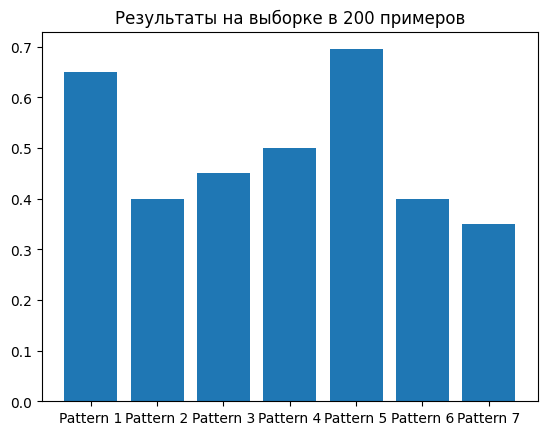

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
x = np.array(["Pattern 1", "Pattern 2", "Pattern 3", "Pattern 4", "Pattern 5", "Pattern 6", "Pattern 7"])
y = np.array([f_1, f_2, f_3, f_4, f_5, f_6, f_7])

ax.bar(x, y)
ax.set_title('Результаты на выборке в 200 примеров')
plt.show()

In [ ]:
preds_1_test, preds_2_test, preds_3_test = [], [], []
preds_4_test, preds_5_test, preds_6_test, preds_7_test = [], [], [], []
test_corpus, labels = list(df['Text'][199980:]), [int(x) for x in df['Binary'][199980:]]
for text in test_corpus:
      preds_1_test.extend(basic_prompt_prediction(pattern_1, [text]))
      preds_2_test.extend(basic_prompt_prediction(pattern_2, [text]))
      preds_3_test.extend(basic_prompt_prediction(pattern_3, [text]))
      preds_4_test.extend(basic_prompt_prediction(pattern_4, [text]))
      preds_5_test.extend(new_advanced_prompt_prediction(pattern_5, [text]))
      preds_6_test.extend(new_advanced_prompt_prediction(pattern_6, [text]))
      preds_7_test.extend(new_advanced_prompt_prediction(pattern_7, [text]))

In [ ]:
y_true = labels
f_1 = f1_score(labels, preds_1_test, average='micro')
f_2 = f1_score(labels, preds_2_test, average='micro')
f_3 = f1_score(labels, preds_3_test, average='micro')
f_4 = f1_score(labels, preds_4_test, average='micro')
f_5 = f1_score(labels, preds_5_test, average='micro')
f_6 = f1_score(labels, preds_6_test, average='micro')
f_7 = f1_score(labels, preds_7_test, average='micro')

In [ ]:
results = pd.DataFrame(data=[test_corpus, labels, preds_1_test, preds_2_test, preds_3_test,
                             preds_4_test, preds_5_test, preds_6_test, preds_7_test],
                       index=['Text', 'True', 1, 2, 3, 4, 5, 6, 7]).T

In [ ]:
results

,Text,True,1,2,3,4,5,6,7
0,Author nicholas sparks on the key to happiness...,0,0,1,1,1,0,1,1
1,Kim kardashian responds to south west name rumors,0,0,1,1,0,0,1,1
2,5 ways to plan the perfect marriage proposal,0,0,1,1,0,1,1,1
3,Martin scorsese presides over the jury at the ...,0,0,1,1,1,0,1,1
4,Obama won? that's it i am moving.... ..to usa!,1,0,1,1,0,1,1,1
5,"Meredith ballentine, bootleg market director, ...",0,0,1,1,0,1,1,1
6,Recent data breaches spark debate over 'reason...,0,0,0,1,0,0,1,1
7,"Make no mistake, semi-automatic guns are very ...",0,0,0,0,0,0,0,1
8,What is it called when batman skips church? .....,1,0,1,1,0,1,1,1
9,James foley photo removed from nyc anti-islam ads,0,0,1,1,0,0,1,1


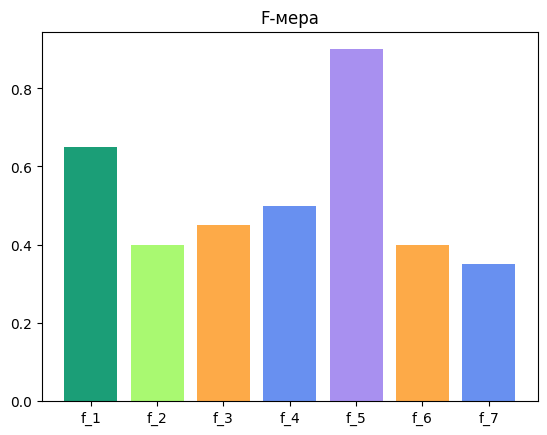

In [ ]:
fig, ax = plt.subplots()

fruits = ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7']
counts = [f_1, f_2, f_3, f_4, f_5, f_6, f_7]
bar_labels = ['darkgreen', 'lightgreen', '#fdaa48','#6890F0','#A890F0','#fdaa48','#6890F0']
bar_colors = ['lightblue', 'lightgreen', 'darkgreen', 'grey', 'lightgrey', 'marn']
c = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0','#fdaa48','#6890F0','#A890F0']

ax.bar(fruits, counts, label=bar_labels, color=c)

# ax.set_ylabel('F-мера')
ax.set_title('F-мера')
# ax.legend(title='Fruit color')

plt.show()

## Few-shot

In [ ]:
test_prompt = """
I'm writing a comedy show. Below are some jokes I've already tested:

The joke: "Why don't skeletons fight each other? They don’t have the guts" It's funny.
The joke: "I told my wife she should embrace her mistakes. She hugged me" It's funny.
The joke: "Abortion goes front and center in alabama senate race" It's not funny.

New joke: "{0}"
Is it funny? My friend says it's <mask>.

"""

In [ ]:
for text, label in zip(results['Text'], results['True']):
    pred = new_advanced_prompt_prediction(test_prompt, [text])
    print(f'Text: {text}\nLabel: {label}\nPredicted label: {pred[0]}\n')

Text: Author nicholas sparks on the key to happiness (video)
Label: 0
Predicted label: 0

Text: Kim kardashian responds to south west name rumors
Label: 0
Predicted label: 1

Text: 5 ways to plan the perfect marriage proposal
Label: 0
Predicted label: 1

Text: Martin scorsese presides over the jury at the marrakech international film festival
Label: 0
Predicted label: 1

Text: Obama won? that's it i am moving.... ..to usa!
Label: 1
Predicted label: 1

Text: Meredith ballentine, bootleg market director, swears by lip pencils for good reason
Label: 0
Predicted label: 1

Text: Recent data breaches spark debate over 'reasonable' notification rules
Label: 0
Predicted label: 0

Text: Make no mistake, semi-automatic guns are very dangerous, no matter whose hands they're in
Label: 0
Predicted label: 0

Text: What is it called when batman skips church? .....christian bale.
Label: 1
Predicted label: 1

Text: James foley photo removed from nyc anti-islam ads
Label: 0
Predicted label: 0

Text: Whe

In [ ]:
new_prompt = """
I'm writing a comedy show. Below are some jokes I've already tested:

The joke: "{0}" It's funny.
The joke: "{1}. She hugged me" It's funny.
The joke: "{2}" It's not funny.

New joke: "{3}"
Is it funny? My friend says it's <mask>.

"""

RAG для подбора примеров для промпта

In [ ]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
df

,Text,Binary
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


In [ ]:
corpus = [str(text) + ". It's " + ['not funny.', 'funny.'][int(label)] for text, label in zip(df['Text'][201:199980], df['Binary'][201:199980])]

In [ ]:
bert_model = AutoModelWithLMHead.from_pretrained(MODEL_NAME).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1833: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
import chromadb
from sentence_transformers import SentenceTransformer

client = chromadb.Client()

collection_name = "corpus_collection"
jokes_collection = client.create_collection(name=collection_name)
model = SentenceTransformer('all-MiniLM-L6-v2')

# corpus = [str(text) + ' ' + str(label) for text, label in zip(df['Texts'][201:199980], df['Binary'][201:199980])]

for i, text in enumerate(corpus):
    embedding = model.encode(text).tolist()
    jokes_collection.add(
        ids=[f"text-{i}"],
        documents=[text],
        embeddings=[embedding],
        metadatas=[{"text": text}]
    )


KeyboardInterrupt: 

In [ ]:
def retrieve_similar_texts(query, model, collection, top_k=3):
    query_embedding = model.encode(query).tolist()

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )

    similar_texts = results['documents'][0]
    return similar_texts

query = "Mcdonald's will officially kick off all-day breakfast on october 6"
retrieved_texts = retrieve_similar_texts(query, model, jokes_collection)
print(retrieved_texts)

["Mcdonalds actually does serve breakfast after 10:30 if u have a gun. It's funny.", "If banks were as fiercely regulated as mcdonalds breakfast cut off time, there'd be no problems.. It's funny.", "Chicago protesters ready black friday march for laquan mcdonald. It's not funny."]


In [ ]:
for text, label in zip(results['Text'], results['True']):
    print(text)
    print(retrieve_similar_texts(text, model, jokes_collection))

Так как лучшее качество было на 5 промпте:



```
pattern_5 = "I'm writing a comedy show. The joke: {0}. Do you find this joke funny? My friend says it's <mask>."
```

Я решила попробовать сначала докрутить его.


In [ ]:
def create_prompt(text, retrieval):
    retrieved_texts = "\n".join(
        [f"The joke: '{joke}'" for joke in retrieval]
    )

    prompt = f"""I'm writing a comedy show. Below are some jokes I've already tested:
    {retrieved_texts}

    New joke: "{text}"
    Is it funny? My friend says it's <mask>.
    """
    return prompt

In [ ]:
for text, label in zip(results['Text'], results['True']):
    print(text)
    prompt = create_prompt(text, retrieve_similar_texts(text, model, jokes_collection))
    print(prompt)

Author nicholas sparks on the key to happiness (video)
I'm writing a comedy show. Below are some jokes I've already tested:
    The joke: 'Want more happiness? it's hidden in the ordinary. It's not funny.'
The joke: 'Happiness defined: your interpretations of what it means to experience joy (photos). It's not funny.'
The joke: 'The key to being happy, no matter what happens. It's not funny.'

    New joke: "Author nicholas sparks on the key to happiness (video)" 
    Is it funny? My friend says it's <mask>.
    
Kim kardashian responds to south west name rumors
I'm writing a comedy show. Below are some jokes I've already tested:
    The joke: 'North west sends her first tweet and we're sure kim k is happy about it. It's not funny.'
The joke: 'Yes, blac chyna plans to change her last name to kardashian. It's not funny.'
The joke: 'I hope kim and kanye surprise everyone and name this next kid something like bill or jen. It's funny.'

    New joke: "Kim kardashian responds to south west n

In [ ]:
def score_with_model(tokenization, index, device="cuda"):
    tensor = torch.LongTensor([tokenization]).to(device)
    with torch.no_grad():
        model_output = bert_model(tensor)
    logits = model_output.logits[0]
    log_probs = torch.log_softmax(logits[index], dim=-1)
    return log_probs

In [ ]:
def few_shot_prompt_prediction(prompt):
    preds = []
    tokenization, mask_index = format_with_pattern(tokenizer, prompt, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=1, dim=-1)
    for log_prob, index in zip(top_probs, top_indexes):
        probability = np.exp(log_prob.item())
        input = tokenizer.decode([index]).replace(' ', '')
        if input == 'not':
            pred = 0
        elif input in ['funny', 'hilarious', 'amusing', 'humorous', 'comical']:
            pred = 1
        else:
            print(text)
            print(input, probability)
            print()
            pred = cosine_similarity(input.replace(" ", ""))
            print(pred)
    preds.append(pred)
        # preds.append(int(pos_prob > neg_prob))
    return preds

In [ ]:
for text, label in zip(results['Text'], results['True']):
    prompt = create_prompt(text, retrieve_similar_texts(text, model, jokes_collection))
    print(text)
    print(label, few_shot_prompt_prediction(prompt)[0])

Author nicholas sparks on the key to happiness (video)
0 1
Kim kardashian responds to south west name rumors
0 1
5 ways to plan the perfect marriage proposal
0 1
Martin scorsese presides over the jury at the marrakech international film festival
0 1
Obama won? that's it i am moving.... ..to usa!
1 1
Meredith ballentine, bootleg market director, swears by lip pencils for good reason
0 1
Recent data breaches spark debate over 'reasonable' notification rules
0 0
Make no mistake, semi-automatic guns are very dangerous, no matter whose hands they're in
0 1
What is it called when batman skips church? .....christian bale.
1 1
James foley photo removed from nyc anti-islam ads
0 1
Where do eskimos keep their money? in snowbanks.
1 1
Meet the billionaire who controls your ketchup, beer
0 1
North korea stages large-scale artillery drill as u.s. submarine docks in south
0 1
What did the child with no arms get for christmas? gloves. just kidding, he hasn't opened it yet.
1 1
Elizabeth taylor looked

Однако тут, кажется, и без анализа, если честно, видно, что промпт очень неудачный, потому что происходит сильный перекос в юмор (вероятно из-за количества слова 'funny' в примерах, данных в подводке). Можно попробовать просить модель распределять либо на юмор, либо на журналистику (все тексты что-то типа новостных).

Попробуем более классический паттерн.



```
Analyze the given text and determine whether it is 'Journalistic'.' Here are some examples. {0}
Now classify this one: {1}. The text is <mask>.
```



In [ ]:
def create_prompt(prompt, text, retrieval):
    retrieved_texts = "\n".join(
        [f"Text: '{retrieved}'" for retrieved in retrieval]
    )

    prompt = prompt.format(retrieved_texts, text)
    return prompt

In [ ]:
pattern_new = """Analyze the given text and determine whether it is 'Journalistic'.' Here are some examples. {0}
Now classify this one: {1}. The text is <mask>."""

In [ ]:
corpus = [str(text) + " The text is " + ['jounalistic.', 'humorous.'][int(label)] for text, label in zip(df['Text'][10000:25000], df['Binary'][10000:25000])]

In [ ]:
client = chromadb.Client()

collection_name = "my_collection"
jokes_collection = client.create_collection(name=collection_name)
model = SentenceTransformer('all-MiniLM-L6-v2')

for i, text in enumerate(corpus):
    embedding = model.encode(text).tolist()
    jokes_collection.add(
        ids=[f"text-{i}"],
        documents=[text],
        embeddings=[embedding],
        metadatas=[{"text": text}]
    )


In [ ]:
preds_fs = []
for text, label in zip(results['Text'], results['True']):
    prompt = create_prompt(pattern_new, text, retrieve_similar_texts(text, model, jokes_collection))
    tokenization, mask_index = format_with_pattern(tokenizer, prompt, text)
    log_probs = score_with_model(tokenization, mask_index)
    top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
    print(text)
    for log_prob, index in zip(top_probs, top_indexes):
        word = tokenizer.decode([index]).replace(' ', '')
        prob = np.exp(log_prob.item())
        # print(word)
        if word == 'humorous':
            pred = 1
            break
        elif word == 'journalistic':
            pred = 0
            break
        else:
            pred = cosine_similarity(word, add_info=[['humorous'], ['journalistic']])
    preds_fs.append(pred)
    print(label, pred)
    print("")

Author nicholas sparks on the key to happiness (video)
0 1

Kim kardashian responds to south west name rumors
0 0

5 ways to plan the perfect marriage proposal
0 0

Martin scorsese presides over the jury at the marrakech international film festival
0 1

Obama won? that's it i am moving.... ..to usa!
1 1

Meredith ballentine, bootleg market director, swears by lip pencils for good reason
0 0

Recent data breaches spark debate over 'reasonable' notification rules
0 0

Make no mistake, semi-automatic guns are very dangerous, no matter whose hands they're in
0 1

What is it called when batman skips church? .....christian bale.
1 1

James foley photo removed from nyc anti-islam ads
0 0

Where do eskimos keep their money? in snowbanks.
1 1

Meet the billionaire who controls your ketchup, beer
0 1

North korea stages large-scale artillery drill as u.s. submarine docks in south
0 1

What did the child with no arms get for christmas? gloves. just kidding, he hasn't opened it yet.
1 1

Elizabeth

In [ ]:
y_true = labels
f_few = f1_score(labels, preds_fs, average='micro')
print(f'Результаты на мини-выборке: {f_few}')

Результаты на мини-выборке: 0.7


In [ ]:
final_corpus, final_labels = list(df['Text'][:200]), [int(x) for x in df['Binary'][:200]]
def final_results(final_corpus, pattern_new):
    preds_fs = []
    for text in final_corpus:
        prompt = create_prompt(pattern_new, text, retrieve_similar_texts(text, model, jokes_collection))
        tokenization, mask_index = format_with_pattern(tokenizer, prompt, text)
        log_probs = score_with_model(tokenization, mask_index)
        top_probs, top_indexes = torch.topk(log_probs, k=5, dim=-1)
        for log_prob, index in zip(top_probs, top_indexes):
            word = tokenizer.decode([index]).replace(' ', '')
            prob = np.exp(log_prob.item())
            if word == 'humorous':
                pred = 1
                break
            elif word == 'journalistic':
                pred = 0
                break
            else:
                pred = cosine_similarity(word, add_info=[['humorous'], ['journalistic']])
        preds_fs.append(pred)
        # print(label, pred)
        # print("")
    return preds_fs

In [ ]:
predictions = final_results(final_corpus, pattern_new)

In [ ]:
f_few_final = f1_score(final_labels, predictions, average='micro')
print(f'Финальная f-мера на выборке в 200 примеров: {f_few_final}')
print()
print(classification_report(final_labels, predictions, target_names=target_names, zero_division=0))

Финальная f-мера на выборке в 200 примеров: 0.735

              precision    recall  f1-score   support

       False       0.93      0.53      0.68       105
        True       0.65      0.96      0.77        95

    accuracy                           0.73       200
   macro avg       0.79      0.75      0.73       200
weighted avg       0.80      0.73      0.72       200



In [ ]:
f_5 = f1_score(final_labels, preds_5_new, average='micro')
print(f'Лучшая f-мера на zero-shot: {f_5}')

Лучшая f-мера на zero-shot: 0.695


**Выводы:**


*   На zero-shot качество было все-таки чуть хуже, чем на few-shot.
*   Для задач zero-shot и few-shot пришлось выбирать разные промпты для лучшего качества; для zero-shot приходится немножко сильнее креативить и даже по сути чуток обманывать модель. Для few-shot лучше подходит примитивный промпт, то есть задачу лучше решать как обычную классификацию.
*   Сама задача, кажется, довольно сложная для zero-shot, существует много статей о том, что для ЛЛМ очень сложно восприятие юмора.
*   Для бинарной классификации по юмору, видимо, не стоит давать модели подводку типа "юмор vs не-юмор", так как это сильно перетягивает bias модели в сторону юмора.



